## ResNET Training for MDSM
### 1. Instrall required pip package

___TODO___
Remove /usr/local/lib/python3.8/dist-packages/shap/explainers/_deep/deep_pytorch.py 228 line source code

```python
print('Warning: unrecognized nn.Module: {}'.format(module_type))
```

### 2. import required python packages

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import shap
import time, sys
import numpy
import os
import math
import itertools

from itertools import combinations
from ResNet import Bottleneck, ResNet, ResNet50, ResNet18, ResNet34, ResNet101, ResNet152, ResNet10, ResNet6
from torch.utils.data import Dataset, Subset
from torch.utils.data.dataset import random_split
from torchvision import models
from torchsummary import summary
from datetime import datetime
from pytz import timezone
from IPython.display import clear_output


def is_running_on_ipython():
    try:
        __IPYTHON__
        return True
    except NameError:
        return False
    
#arg[1]
EPOCHS = 1000
#arg[2]
BATCH_SIZE = 512
#arg[3]
net_type = "ResNet18"
#arg[4]
split_random = True
#arg[5]
path = ""
display_path = ""

web_running = is_running_on_ipython()

def print_out_hyperparameter():
    print("Hyper-parameter of this Running")
    print(f"Working Path[{display_path}], EPOCHS[{EPOCHS}], BATCH_SIZE[{BATCH_SIZE}], Model[{net_type}], Training data Split[{split_random}]")

if len(sys.argv) >= 2 and web_running == False:
    for i in range(1, len(sys.argv)):
        if i == 1:
            path = sys.argv[i] + "/"
        elif i == 2:
            EPOCHS = int(sys.argv[i])
        elif i == 3:
            BATCH_SIZE = int(sys.argv[i])
        elif i == 4:
            net_type = sys.argv[i]
        elif i == 5:
            split_random = eval(sys.argv[i])

display_path = path;

print_out_hyperparameter()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mdsm_width = 11
mdsm_height = 108
trans_stat = True


now = datetime.now(timezone('Asia/Seoul'))
time_str = now.strftime('%Y-%m-%d_%H%M%S')
hyperparameter_str = "model-{}_epochs-{}-batch-{}-randomsplit-{}-{}".format(net_type, EPOCHS, BATCH_SIZE, split_random, time_str)

data_path = path
if web_running:
    path = path + "results/" + time_str + "_jupyter/"
else:
    path = path + "results/" + time_str + "/"
os.makedirs(path)
os.makedirs(path + "training_metrics")
os.makedirs(path + "check_points")
os.makedirs(path + "graphs")

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.14) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


Hyper-parameter of this Running
Working Path[], EPOCHS[1000], BATCH_SIZE[512], Model[ResNet18], Training data Split[True]


### 3. Define MDSMdata set for torch Dataset and Dataloader and other
* mix_random : For preventing overfitting (Mixing row randomly in MDSM metric
* flip_random : For preventing overfitting (Flip MDSM upside-down)

In [2]:
def mix_random(col, row, mdsm_body):
    size_suffle = random.randint(0,10)
    switchsource = torch.randint(0, row - 1, (size_suffle,))
    temp = np.zeros((1, col), np.float32)
    
    for i in range(0, int(size_suffle)):
        if i == switchsource[i]:
            continue
        temp = mdsm_body[i, :].copy()
        mdsm_body[i, :] = mdsm_body[switchsource[i], :].copy()
        mdsm_body[switchsource[i], :] = temp.copy()
    return torch.tensor(mdsm_body)

def flip_random(col, row, mdsm_body):
    size_suffle = random.randint(0,12)
    if size_suffle % 4 != 0:
        return torch.tensor(mdsm_body)
    
    int_row = int(row)
    for i in range(0, int(int_row / 2)):
        temp = mdsm_body[i, :].copy()
        mdsm_body[i, :] = mdsm_body[int_row - i - 1, :].copy()
        mdsm_body[int_row - i - 1, :] = temp.copy()
    return torch.tensor(mdsm_body)
    
class MDSMDataset(Dataset):
    def __init__(self, mdsmdata_file):
        self.df = pd.read_csv(mdsmdata_file)
        rating = self.df[['ReviewID', 'reviewStar']]
        self.rating = rating.drop_duplicates('ReviewID')
        if trans_stat == True:
            self.height = self.df['ReviewID'].value_counts().max()
            #print(self.height)
        else:
            #Hardcoding for current dataset
            self.height = 108
            self.height = 100

        mdsm_body = self.df.drop(['reviewNo', 'reviewStar', 'mGNR'], axis=1)
        mdsm_body['imageCnt'] = (mdsm_body['imageCnt'] - mdsm_body['imageCnt'].min())/ (mdsm_body['imageCnt'].max() - mdsm_body['imageCnt'].min())
        mdsm_body['helpfulCnt'] = (mdsm_body['helpfulCnt'] - mdsm_body['helpfulCnt'].mean())/ mdsm_body['helpfulCnt'].std()
        body_height, body_width = mdsm_body.shape;
        self.width = body_width - 1
        mdsm_width = self.width
        if trans_stat == True:
            mdsm_height = self.height
        
        dummy_mdsd = np.zeros((body_height, self.height, self.width), np.float32)
        mdsm_index = np.zeros(self.rating['ReviewID'].max()+1, int)
        mdsm_count = np.zeros(self.rating['ReviewID'].max()+1, int)
        mdsm_index.fill(-1)

        max_index = int(0)
        for index, body in mdsm_body.iterrows():
            dummy_index = max_index
            if mdsm_index[int(body['ReviewID'])] != -1:
                dummy_index = mdsm_index[int(body['ReviewID'])]
            else:
                mdsm_index[int(body['ReviewID'])] = dummy_index
                max_index = max_index + 1

            dummy_mdsd[dummy_index, mdsm_count[dummy_index]] = body.drop('ReviewID')
            mdsm_count[dummy_index] = mdsm_count[dummy_index] + 1

        self.mdsm_body = dummy_mdsd
            
    def __len__(self):
        return self.rating.shape[0]

    
    def __getitem__(self, idx):
        if trans_stat == True:
            _tensor = flip_random(self.width, self.height, self.mdsm_body[idx])
        else:
            _tensor = torch.tensor(self.mdsm_body[idx])
        rtn_tensor = _tensor.unsqueeze(0)
        return rtn_tensor, self.rating.iloc[idx, 1]

### 4. Hyperparameter setting
* epochs, batch_size ResNet layer number
* select ResNet model
* print out Model strucuture

In [3]:
if net_type == "ResNet6":
    net = ResNet6(6, 1).to('cuda')
elif net_type == "ResNet10":
    net = ResNet10(6, 1).to('cuda')
elif net_type == "ResNet18":
    net = ResNet18(6, 1).to('cuda')
    print("ResNet18 is used")
elif net_type == "ResNet34":
    net = ResNet34(6, 1).to('cuda')
    print("ResNet34 is used")
elif net_type == "ResNet50":
    net = ResNet50(6, 1).to('cuda')
    print("ResNet50 is used")
elif net_type == "ResNet101":
    net = ResNet101(6, 1).to('cuda')
    print("ResNet101 is used")
elif net_type == "ResNet152":
    net = ResNet152(6, 1).to('cuda')
    print("ResNet152 is used")

summary(net, (1, mdsm_height, mdsm_width))

ResNet18 is used
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 64, 54, 6]           3,136
       BatchNorm2d-2            [-1, 64, 54, 6]             128
              ReLU-3            [-1, 64, 54, 6]               0
         MaxPool2d-4            [-1, 64, 27, 3]               0
            Conv2d-5            [-1, 64, 27, 3]          36,864
       BatchNorm2d-6            [-1, 64, 27, 3]             128
           Dropout-7            [-1, 64, 27, 3]               0
           Dropout-8            [-1, 64, 27, 3]               0
            Conv2d-9            [-1, 64, 27, 3]          36,864
      BatchNorm2d-10            [-1, 64, 27, 3]             128
       BasicBlock-11            [-1, 64, 27, 3]               0
           Conv2d-12            [-1, 64, 27, 3]          36,864
      BatchNorm2d-13            [-1, 64, 27, 3]             128
          Dropout-14  

### 5. Load MDSM dataset from preprocesed csv file
* split train and test dataset into 8:2 ratio
* 6 kinds of classess [0, 1, 2, 3, 4, 5]

In [4]:
print('-- Loading dataset--')

dataset = MDSMDataset(data_path + 'amazon_hmdvr_df_tokenized_sentiment_score_extended_normalized_nonzero_dist_3.csv')
#dataset = MDSMDataset(data_path + 'amazon_hmdvr_df_tokenized_sentiment_score_extended_normalized.csv')
#dataset = MDSMDataset(data_path + 'amazon_hmdvr_df_tokenized_sentiment_score_extended.csv')
train_size = round(len(dataset) * 0.8)
test_size = len(dataset) - train_size

-- Loading dataset--


In [5]:
len(dataset)

12754

In [6]:

print("Train(", train_size, ") vs Test(", test_size, ")")

print('-- Building train and test dataset / dataloader--')

if split_random:
    print("Training dataset is selected random")
    train_dataset, test_dataset = random_split(dataset, [int(train_size),int(test_size)])
else:
    print("Training dataset is selected fixed")
    train_dataset = Subset(dataset, numpy.arange(1, train_size))
    test_dataset = Subset(dataset, numpy.arange(train_size, len(dataset)))

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle=True, num_workers=0)

classes = ['0', '1', '2', '3', '4', '5']


Train( 10203 ) vs Test( 2551 )
-- Building train and test dataset / dataloader--
Training dataset is selected random


### 6. Define mae and mse calcuating function

In [7]:
def calcu_metric(outputs, labels):
    mae = abs(outputs - labels)
    mse = torch.pow((outputs - labels), 2)
    mape = abs((outputs-labels)/labels)
    mbe = outputs - labels
    return mae, mse, mape, mbe

### 7. Do ResNet training

In [8]:
print_out_hyperparameter()



criterion = nn.CrossEntropyLoss()


#criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, patience=5)

correct = 0
total = 0

print('-- Start training : ', EPOCHS, 'epochs')
start = time.time()

mse_history = {'train': [], 'val': []}
rmse_history = {'train': [], 'val': []}
mae_history = {'train': [], 'val': []}
mape_history = {'train': [], 'val': []}
mbe_history = {'train': [], 'val': []}
loss_history = {'train': [], 'val': []}
acc_history = {'train': [], 'val': []}

for epoch in range(EPOCHS):
    losses = []
    
    mse = np.zeros(train_size, np.float32)
    mae = np.zeros(train_size, np.float32)
    mape = np.zeros(train_size, np.float32)
    mbe = np.zeros(train_size, np.float32)
    rmse = np.zeros(train_size, np.float32)
    
    val_mse = np.zeros(test_size, np.float32)
    val_mae = np.zeros(test_size, np.float32)
    val_mape = np.zeros(test_size, np.float32)
    val_mbe = np.zeros(test_size, np.float32)
    val_rmse = np.zeros(train_size, np.float32)
    
    metric_index = 0
    
    running_loss = 0
    train_loss = 0
    train_acc = 0
    val_acc = 0
    for i, inp in enumerate(trainloader):
        inputs, labels = inp
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        optimizer.zero_grad()

        outputs = net(inputs)
    
        pred = outputs.data.max(1, keepdim=True)[1]
        train_acc += pred.eq(labels.data.view_as(pred)).sum()
    
        loss = criterion(outputs, labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_loss += loss.item()

        _mae, _mse, _mape, _mbe = calcu_metric(pred.squeeze(), labels)
          #print(_mse.detach().cpu().numpy())
        mae[metric_index:metric_index+len(inputs)] = _mae.detach().cpu().numpy()
        mse[metric_index:metric_index+len(inputs)] = _mse.detach().cpu().numpy()
        mape[metric_index:metric_index+len(inputs)] = _mape.detach().cpu().numpy()
        mbe[metric_index:metric_index+len(inputs)] = _mbe.detach().cpu().numpy()
        #print(torch.tensor(mse))
        metric_index += len(inputs)
        
        if i%100 == 0 and i > 0:
            print(f'Loss [{epoch+1}/{EPOCHS}, {i}](epoch, minibatch): ', f'{running_loss / 100:.5f}')
            running_loss = 0.0

    mae_epoch = torch.mean(torch.tensor(mae))
    mse_epoch = torch.mean(torch.tensor(mse))
    rmse_epoch = torch.sqrt(mse_epoch)
    mape_epoch = torch.mean(torch.tensor(mape))*100
    mbe_epoch = torch.mean(torch.tensor(mbe))
    
    mse_history['train'].append(mse_epoch)
    rmse_history['train'].append(rmse_epoch)
    mae_history['train'].append(mae_epoch)
    mape_history['train'].append(mape_epoch)
    mbe_history['train'].append(mbe_epoch)
    
    avg_loss = sum(losses)/len(losses)
    scheduler.step(avg_loss)
    
    metric_index = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to('cuda'), labels.to('cuda')
            outputs = net(images)

            pred = outputs.data.max(1, keepdim=True)[1]
            val_acc += pred.eq(labels.data.view_as(pred)).sum()
        
            _mae, _mse, _mape, _mbe  = calcu_metric(pred.squeeze(), labels)
            val_mae[metric_index:metric_index+len(images)] = _mae.detach().cpu().numpy()
            val_mse[metric_index:metric_index+len(images)] = _mse.detach().cpu().numpy()
            val_mape[metric_index:metric_index+len(images)] = _mape.detach().cpu().numpy()
            val_mbe[metric_index:metric_index+len(images)] = _mbe.detach().cpu().numpy()
            metric_index += len(images)           
        
    val_mae_epoch = torch.mean(torch.tensor(val_mae))
    val_mse_epoch = torch.mean(torch.tensor(val_mse))
    val_rmse_epoch = torch.sqrt(val_mse_epoch)
    val_mape_epoch = torch.mean(torch.tensor(val_mape))*100
    val_mbe_epoch = torch.mean(torch.tensor(val_mbe))
    mse_history['val'].append(val_mse_epoch)
    rmse_history['val'].append(val_rmse_epoch)
    mae_history['val'].append(val_mae_epoch)
    mape_history['val'].append(val_mape_epoch)
    mbe_history['val'].append(val_mbe_epoch)
    
    acc_history['train'].append((100. * train_acc / len(trainloader.dataset)).detach().cpu().numpy())
    acc_history['val'].append((100. * val_acc / len(testloader.dataset)).detach().cpu().numpy())
    
    train_loss /= len(trainloader.dataset)
    if EPOCHS > 50:
        if epoch % 5 == 0:
            print('Epoch: {}/{} Avg. loss:{:.4f} Acc.: {:.4f}% '.format(epoch, EPOCHS, train_loss, 100. * train_acc / len(trainloader.dataset)), f"MAE : {mae_epoch.item():.3f}", f"MSE : {mse_epoch.item():.3f}", f"VAL_MAE : {val_mae_epoch.item():.3f}", f"VAL_MSE : {val_mse_epoch.item():.3f}" ")")
    else:
        print('Epoch: {}/{} Avg. loss:{:.4f} Acc.: {:.4f}% '.format(epoch, EPOCHS, train_loss, 100. * train_acc / len(trainloader.dataset)), f"MAE : {mae_epoch.item():.3f}", f"MSE : {mse_epoch.item():.3f}", f"VAL_MAE : {val_mae_epoch.item():.3f}", f"VAL_MSE : {val_mse_epoch.item():.3f}" ")")

print('Training Done')
trans_stat = False
end = time.time()
print(f"{net_type} training takes {end - start:.5f} sec")

Hyper-parameter of this Running
Working Path[], EPOCHS[1000], BATCH_SIZE[512], Model[ResNet18], Training data Split[True]
-- Start training :  1000 epochs
Epoch: 0/1000 Avg. loss:0.0035 Acc.: 56.0913%  MAE : 1.209 MSE : 4.070 VAL_MAE : 1.119 VAL_MSE : 3.730)
Epoch: 5/1000 Avg. loss:0.0021 Acc.: 63.6577%  MAE : 0.894 MSE : 2.796 VAL_MAE : 0.893 VAL_MSE : 2.828)
Epoch: 10/1000 Avg. loss:0.0020 Acc.: 64.3830%  MAE : 0.863 MSE : 2.672 VAL_MAE : 0.904 VAL_MSE : 2.864)
Epoch: 15/1000 Avg. loss:0.0020 Acc.: 64.4810%  MAE : 0.855 MSE : 2.637 VAL_MAE : 0.909 VAL_MSE : 2.890)
Epoch: 20/1000 Avg. loss:0.0020 Acc.: 64.9515%  MAE : 0.839 MSE : 2.581 VAL_MAE : 0.903 VAL_MSE : 2.848)
Epoch: 25/1000 Avg. loss:0.0019 Acc.: 65.3533%  MAE : 0.827 MSE : 2.535 VAL_MAE : 0.906 VAL_MSE : 2.865)
Epoch: 30/1000 Avg. loss:0.0019 Acc.: 65.8826%  MAE : 0.804 MSE : 2.445 VAL_MAE : 0.912 VAL_MSE : 2.900)
Epoch: 35/1000 Avg. loss:0.0019 Acc.: 65.8434%  MAE : 0.809 MSE : 2.472 VAL_MAE : 0.883 VAL_MSE : 2.751)
Epoch: 

Epoch: 385/1000 Avg. loss:0.0011 Acc.: 80.9272%  MAE : 0.513 MSE : 1.699 VAL_MAE : 0.941 VAL_MSE : 2.832)
Epoch: 390/1000 Avg. loss:0.0011 Acc.: 81.2114%  MAE : 0.504 MSE : 1.667 VAL_MAE : 0.949 VAL_MSE : 2.846)
Epoch: 395/1000 Avg. loss:0.0011 Acc.: 80.7606%  MAE : 0.517 MSE : 1.706 VAL_MAE : 0.942 VAL_MSE : 2.846)
Epoch: 400/1000 Avg. loss:0.0011 Acc.: 80.7998%  MAE : 0.514 MSE : 1.695 VAL_MAE : 0.949 VAL_MSE : 2.858)
Epoch: 405/1000 Avg. loss:0.0011 Acc.: 80.8782%  MAE : 0.513 MSE : 1.694 VAL_MAE : 0.947 VAL_MSE : 2.850)
Epoch: 410/1000 Avg. loss:0.0011 Acc.: 81.0056%  MAE : 0.512 MSE : 1.698 VAL_MAE : 0.953 VAL_MSE : 2.869)
Epoch: 415/1000 Avg. loss:0.0011 Acc.: 80.9664%  MAE : 0.510 MSE : 1.684 VAL_MAE : 0.948 VAL_MSE : 2.863)
Epoch: 420/1000 Avg. loss:0.0011 Acc.: 81.0154%  MAE : 0.508 MSE : 1.677 VAL_MAE : 0.946 VAL_MSE : 2.845)
Epoch: 425/1000 Avg. loss:0.0011 Acc.: 81.4662%  MAE : 0.497 MSE : 1.641 VAL_MAE : 0.930 VAL_MSE : 2.794)
Epoch: 430/1000 Avg. loss:0.0011 Acc.: 80.7018

Epoch: 775/1000 Avg. loss:0.0011 Acc.: 80.8978%  MAE : 0.513 MSE : 1.697 VAL_MAE : 0.955 VAL_MSE : 2.862)
Epoch: 780/1000 Avg. loss:0.0011 Acc.: 80.9468%  MAE : 0.511 MSE : 1.690 VAL_MAE : 0.945 VAL_MSE : 2.826)
Epoch: 785/1000 Avg. loss:0.0011 Acc.: 81.0938%  MAE : 0.508 MSE : 1.679 VAL_MAE : 0.928 VAL_MSE : 2.774)
Epoch: 790/1000 Avg. loss:0.0011 Acc.: 80.9272%  MAE : 0.511 MSE : 1.689 VAL_MAE : 0.930 VAL_MSE : 2.789)
Epoch: 795/1000 Avg. loss:0.0011 Acc.: 81.1820%  MAE : 0.504 MSE : 1.660 VAL_MAE : 0.951 VAL_MSE : 2.866)
Epoch: 800/1000 Avg. loss:0.0011 Acc.: 80.9762%  MAE : 0.509 MSE : 1.677 VAL_MAE : 0.933 VAL_MSE : 2.788)
Epoch: 805/1000 Avg. loss:0.0011 Acc.: 81.0448%  MAE : 0.509 MSE : 1.683 VAL_MAE : 0.953 VAL_MSE : 2.879)
Epoch: 810/1000 Avg. loss:0.0011 Acc.: 81.0056%  MAE : 0.505 MSE : 1.660 VAL_MAE : 0.956 VAL_MSE : 2.865)
Epoch: 815/1000 Avg. loss:0.0011 Acc.: 80.6919%  MAE : 0.516 MSE : 1.704 VAL_MAE : 0.979 VAL_MSE : 2.975)
Epoch: 820/1000 Avg. loss:0.0011 Acc.: 81.2016

In [9]:
pred = outputs.data.max(1, keepdim=True)[1]
pred.squeeze()

tensor([5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 3, 5, 5, 5, 5, 5, 5, 1, 5, 5,
        5, 5, 5, 1, 5, 5, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 1, 5, 5, 1, 5, 5, 1, 1, 5, 5, 5, 5, 3, 5, 5, 5, 5, 5,
        1, 5, 5, 1, 5, 5, 5, 5, 5, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 5, 5, 5, 5,
        5, 5, 4, 5, 4, 5, 5, 5, 5, 5, 5, 5, 3, 5, 5, 5, 5, 5, 1, 5, 5, 5, 1, 2,
        5, 1, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 1, 5, 1, 5, 2, 5, 5, 5, 5, 5, 1, 1,
        5, 5, 5, 5, 5, 2, 5, 5, 5, 1, 2, 1, 5, 5, 5, 5, 5, 1, 1, 5, 4, 5, 5, 1,
        5, 5, 5, 5, 5, 1, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5,
        5, 5, 5, 5, 1, 5, 1, 5, 5, 2, 3, 5, 5, 5, 4, 5, 5, 5, 1, 5, 3, 1, 5, 4,
        5, 5, 5, 2, 5, 4, 5, 3, 1, 5, 5, 5, 5, 2, 5, 1, 5, 5, 4, 5, 2, 5, 5, 5,
        5, 1, 5, 4, 3, 5, 5, 5, 2, 3, 1, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        1, 5, 2, 5, 5, 5, 1, 5, 5, 5, 5, 4, 5, 1, 1, 5, 5, 5, 5, 2, 2, 5, 2, 5,
        5, 5, 2, 5, 5, 2, 5, 5, 5, 5, 1,

### 8. Save model metrics into csv file
* Hyperparameter were written in filename

In [10]:
hist_csv = np.stack([mae_history['val'], mse_history['val'], rmse_history['val'], mape_history['val'], mbe_history['val'], 
                     acc_history['val'],
                     mae_history['train'], mse_history['train'], rmse_history['train'], mape_history['train'],mbe_history['train'],
                     acc_history['train']], 1)
hist_csv_df = pd.DataFrame(hist_csv)
hist_csv_df.columns = ['validation_mae', 'validation_mse', 'validation_rmse', 'validation_mape', 'validation_mbe', 'validation_accuracy',
                       'train_mae', 'train_mse', 'train_rmse', 'train_mape', 'train_mbe', 'train_accuracy']

hist_csv_df.to_csv("{}training_metrics/amazon_hmdvr_df_tokenized_sentiment_score_{}.csv"
                   .format(path, hyperparameter_str), index=False)
print("{}training_metrics/amazon_hmdvr_df_tokenized_sentiment_score_{}.csv saved"
                   .format(path, hyperparameter_str))

torch.save({
                "epoch": EPOCHS,
                "model_state_dict": net.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
            }, "{}check_points/amazon_hmdvr_df_tokenized_sentiment_score_{}.pt".format(path, hyperparameter_str))
torch.save({
                "epoch": EPOCHS,
                "model_state_dict": net.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
            },path + "check_points/latest.pt")
torch.save(net, "{}check_points/amazon_hmdvr_df_tokenized_sentiment_score_.model".format(path, hyperparameter_str))
torch.save(net, path + "check_points/latest.model")

print("{}check_points/amazon_hmdvr_df_tokenized_sentiment_score_.pt & check_points/latest.pt saved".format(path, hyperparameter_str))

results/2023-03-10_102412_jupyter/training_metrics/amazon_hmdvr_df_tokenized_sentiment_score_model-ResNet18_epochs-1000-batch-512-randomsplit-True-2023-03-10_102412.csv saved
results/2023-03-10_102412_jupyter/check_points/amazon_hmdvr_df_tokenized_sentiment_score_.pt & check_points/latest.pt saved


### 9. Plot model metrics

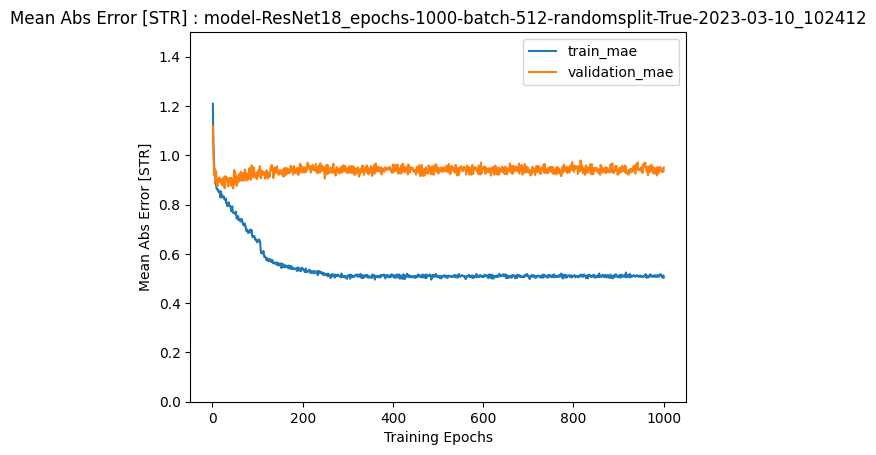

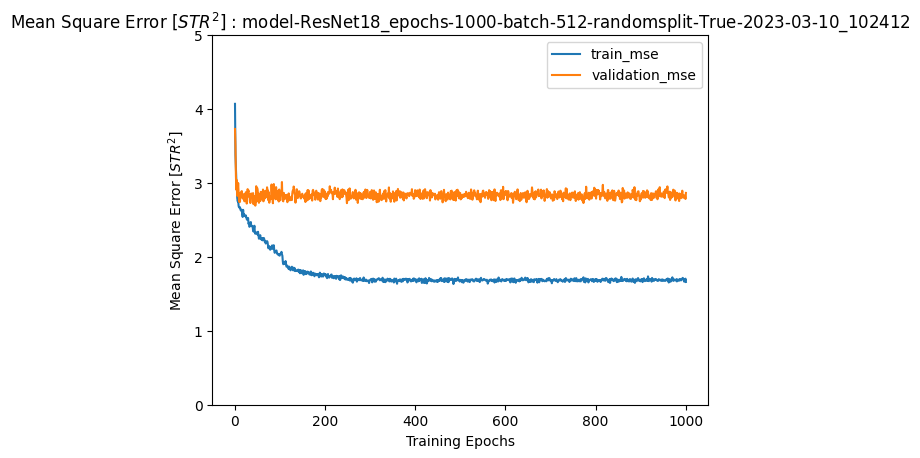

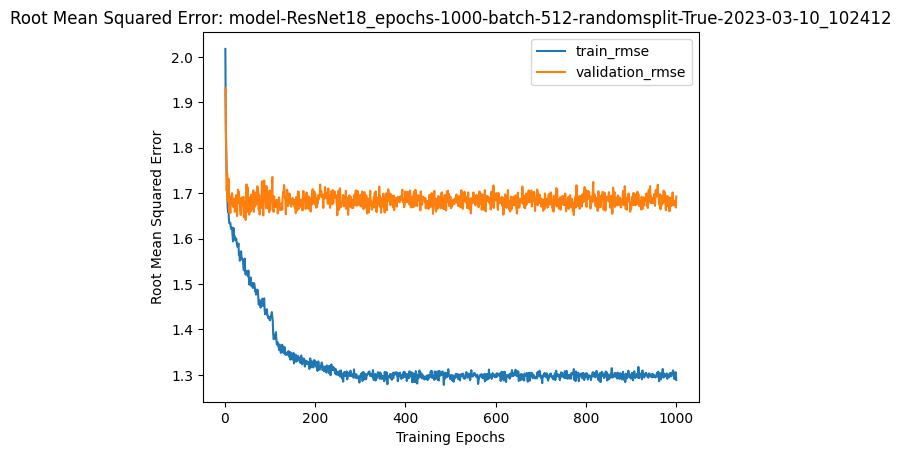

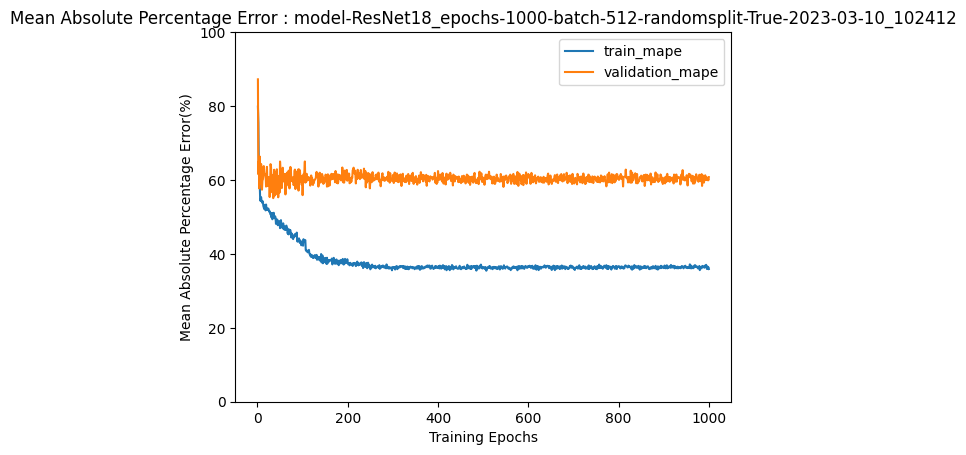

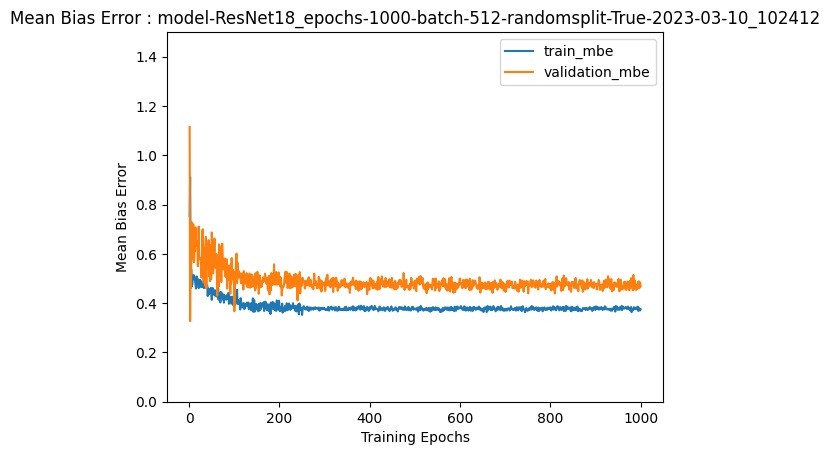

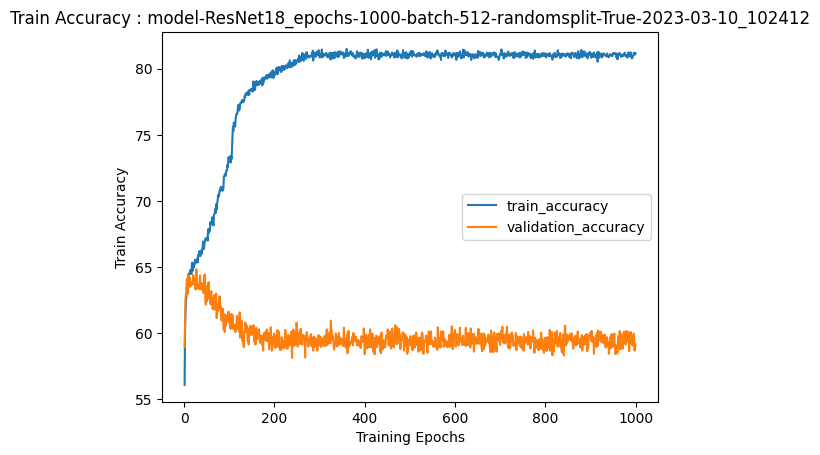

In [11]:
if web_running == True:
    plt.title("Mean Abs Error [STR] : {}".format(hyperparameter_str))
    plt.plot(range(1,EPOCHS+1),mae_history["train"],label="train_mae")
    plt.plot(range(1,EPOCHS+1),mae_history["val"],label="validation_mae")
    plt.ylabel("Mean Abs Error [STR]")
    plt.xlabel("Training Epochs")
    plt.ylim([0,1.5])
    plt.legend()
    plt.show()

    plt.title("Mean Square Error [$STR^2$] : {}".format(hyperparameter_str))
    plt.plot(range(1,EPOCHS+1),mse_history["train"],label="train_mse")
    plt.plot(range(1,EPOCHS+1),mse_history["val"],label="validation_mse")
    plt.ylabel("Mean Square Error [$STR^2$]")
    plt.xlabel("Training Epochs")
    plt.ylim([0,5])
    plt.legend()
    plt.show()

    plt.title("Root Mean Squared Error: {}".format(hyperparameter_str))
    plt.plot(range(1,EPOCHS+1),rmse_history["train"],label="train_rmse")
    plt.plot(range(1,EPOCHS+1),rmse_history["val"],label="validation_rmse")
    plt.ylabel("Root Mean Squared Error")
    plt.xlabel("Training Epochs")
    #plt.ylim([0,1.5])
    plt.legend()
    plt.show()

    plt.title("Mean Absolute Percentage Error : {}".format(hyperparameter_str))
    plt.plot(range(1,EPOCHS+1),mape_history["train"],label="train_mape")
    plt.plot(range(1,EPOCHS+1),mape_history["val"],label="validation_mape")
    plt.ylabel("Mean Absolute Percentage Error(%)")
    plt.xlabel("Training Epochs")
    plt.ylim([0,100])
    plt.legend()
    plt.show()

    plt.title("Mean Bias Error : {}".format(hyperparameter_str))
    plt.plot(range(1,EPOCHS+1),mbe_history["train"],label="train_mbe")
    plt.plot(range(1,EPOCHS+1),mbe_history["val"],label="validation_mbe")
    plt.ylabel("Mean Bias Error")
    plt.xlabel("Training Epochs")
    plt.ylim([0,1.5])
    plt.legend()
    plt.show()

    plt.title("Train Accuracy : {}".format(hyperparameter_str))
    plt.plot(range(1,EPOCHS+1),acc_history["train"],label="train_accuracy")
    plt.plot(range(1,EPOCHS+1),acc_history["val"],label="validation_accuracy")
    #plt.plot(range(1,EPOCHS+1),mse_history["val"],label="validation mse")
    plt.ylabel("Train Accuracy")
    plt.xlabel("Training Epochs")
    #plt.ylim([0,1.5])
    plt.legend()
    plt.show()

In [12]:
plt.clf()
plt.title("Mean Abs Error [STR] : {}".format(hyperparameter_str))
plt.plot(range(1,EPOCHS+1),mae_history["train"],label="train_mae")
plt.plot(range(1,EPOCHS+1),mae_history["val"],label="validation_mae")
plt.ylabel("Mean Abs Error [STR]")
plt.xlabel("Training Epochs")
plt.ylim([0,1.5])
plt.legend()
plt.savefig(path + "graphs/amazon_hmdvr_df_tokenized_sentiment_score_mae_{}.png".format(hyperparameter_str), dpi=300)

plt.clf()
plt.title("Mean Square Error [$STR^2$] : {}".format(hyperparameter_str))
plt.plot(range(1,EPOCHS+1),mse_history["train"],label="train_mse")
plt.plot(range(1,EPOCHS+1),mse_history["val"],label="validation_mse")
plt.ylabel("Mean Square Error [$STR^2$]")
plt.xlabel("Training Epochs")
plt.ylim([0,5])
plt.legend()
plt.savefig(path + "graphs/amazon_hmdvr_df_tokenized_sentiment_score_mse_{}.png".format(hyperparameter_str), dpi=300)

plt.clf()
plt.title("Root Mean Squared Error: {}".format(hyperparameter_str))
plt.plot(range(1,EPOCHS+1),rmse_history["train"],label="train_rmse")
plt.plot(range(1,EPOCHS+1),rmse_history["val"],label="validation_rmse")
plt.ylabel("Root Mean Squared Error")
plt.xlabel("Training Epochs")
#plt.ylim([0,1.5])
plt.legend()
plt.savefig(path + "graphs/amazon_hmdvr_df_tokenized_sentiment_score_rmse_{}.png".format(hyperparameter_str), dpi=300)

plt.clf()
plt.title("Mean Absolute Percentage Error : {}".format(hyperparameter_str))
plt.plot(range(1,EPOCHS+1),mape_history["train"],label="train_mape")
plt.plot(range(1,EPOCHS+1),mape_history["val"],label="validation_mape")
plt.ylabel("Mean Absolute Percentage Error(%)")
plt.xlabel("Training Epochs")
plt.ylim([0,100])
plt.legend()
plt.savefig(path + "graphs/amazon_hmdvr_df_tokenized_sentiment_score_mape_{}.png".format(hyperparameter_str), dpi=300)

plt.clf()
plt.title("Mean Bias Error : {}".format(hyperparameter_str))
plt.plot(range(1,EPOCHS+1),mbe_history["train"],label="train_mbe")
plt.plot(range(1,EPOCHS+1),mbe_history["val"],label="validation_mbe")
plt.ylabel("Mean Bias Error")
plt.xlabel("Training Epochs")
plt.ylim([0,1.5])
plt.legend()
plt.savefig(path + "graphs/amazon_hmdvr_df_tokenized_sentiment_score_mbe_{}.png".format(hyperparameter_str), dpi=300)

plt.clf()
plt.title("Train Accuracy : {}".format(hyperparameter_str))
plt.plot(range(1,EPOCHS+1),acc_history["train"],label="train_accuracy")
plt.plot(range(1,EPOCHS+1),acc_history["val"],label="validation_accuracy")
#plt.plot(range(1,EPOCHS+1),mse_history["val"],label="validation mse")
plt.ylabel("Train Accuracy")
plt.xlabel("Training Epochs")
#plt.ylim([0,1.5])
plt.legend()
plt.savefig(path + "graphs/amazon_hmdvr_df_tokenized_sentiment_score_acc_{}.png".format(hyperparameter_str), dpi=300)

In [13]:
#confus_loader = torch.utils.data.DataLoader(dataset, batch_size = len(dataset), shuffle=True, num_workers=0)
confus_loader = torch.utils.data.DataLoader(test_dataset, batch_size = len(test_dataset), shuffle=True, num_workers=0)
batch_confus = next(iter(confus_loader))
torch.cuda.empty_cache()
with torch.no_grad():
    images, labels = batch_confus
    images, labels = images.to('cuda'), labels.to('cuda')
    outputs_confus = net(images)
    pred_confus = outputs_confus.data.max(1, keepdim=True)[1]

In [14]:
confusmatirx = np.zeros((5, 5), np.int64)
for idx, val in enumerate(labels):
    confusmatirx[val-1][pred_confus[idx]-1] += 1
confusmatirx

array([[ 126,   31,   24,   19,  261],
       [  32,    9,   19,   11,   69],
       [  21,   11,    8,    9,   93],
       [  22,   11,   15,   33,  223],
       [  44,   20,   34,   78, 1328]])

In [15]:
def plot_confusion_matrix(cm, target_names=None, cmap=None, normalize=True, labels=True, title='Confusion matrix'):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.clf()
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)
    
    if labels:
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            if normalize:
                plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")
            else:
                plt.text(j, i, "{:,}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    if web_running == True:
        plt.show()
    else:
        plt.tight_layout()
        plt.savefig(path + "graphs/amazon_hmdvr_df_tokenized_sentiment_score_confustion_{}.png".format(hyperparameter_str), dpi=300)

<Figure size 640x480 with 0 Axes>

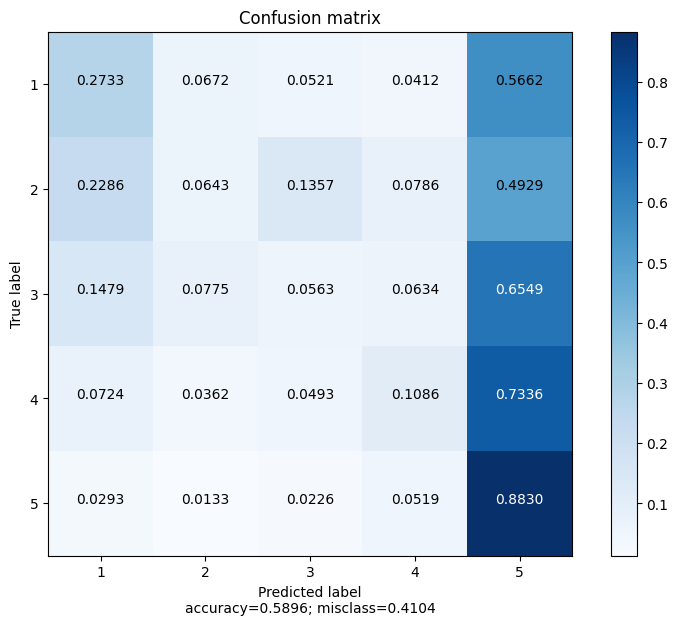

In [16]:
plot_confusion_matrix(confusmatirx, target_names=['1', '2', '3', '4', '5'])

### 10. Using SHAP for XAI 

In [17]:
hyperparameter_str

'model-ResNet18_epochs-1000-batch-512-randomsplit-True-2023-03-10_102412'